In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
from fastai import *
from fastai.vision import *
from fastai.callbacks import CSVLogger
import pandas as pd
%matplotlib inline
import fastai.distributed
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_label = pd.read_csv("/data/Pathology/SPIE/training_set/breastpathq/datasets/train_labels.csv")
val_label = pd.read_csv("/data/Pathology/SPIE/training_set/breastpathq/datasets/val_labels.csv")

In [3]:
train_label.head()

slide  rid     y
0  99861    1  0.40
1  99861    2  0.40
2  99861    3  0.15
3  99861    4  0.10
4  99861    5  0.07

In [4]:
train_label['slide_name'] = "train/"+ train_label['slide'].astype(str) + "_" + train_label['rid'].astype(str) + ".tif"
val_label['slide_name'] = "validation/"+ val_label['slide'].astype(str) + "_" + val_label['rid'].astype(str) + ".tif"
train_label['is_valid'] = False
val_label['is_valid'] = True

In [5]:
full_label = train_label.append(val_label)
full_label.shape

(2579, 5)

In [6]:
full_label.tail()

slide  rid    y               slide_name  is_valid
180  99854   41  0.0  validation/99854_41.tif      True
181  99854   42  0.0  validation/99854_42.tif      True
182  99854   43  0.0  validation/99854_43.tif      True
183  99854   44  0.0  validation/99854_44.tif      True
184  99854   45  0.0  validation/99854_45.tif      True

In [7]:
full_label.head()

slide  rid     y         slide_name  is_valid
0  99861    1  0.40  train/99861_1.tif     False
1  99861    2  0.40  train/99861_2.tif     False
2  99861    3  0.15  train/99861_3.tif     False
3  99861    4  0.10  train/99861_4.tif     False
4  99861    5  0.07  train/99861_5.tif     False

In [8]:
full_label.to_csv("/data/yuyue/SPIE/full_label.csv", index=False)

In [9]:
imgs = full_label.sample(6).slide_name

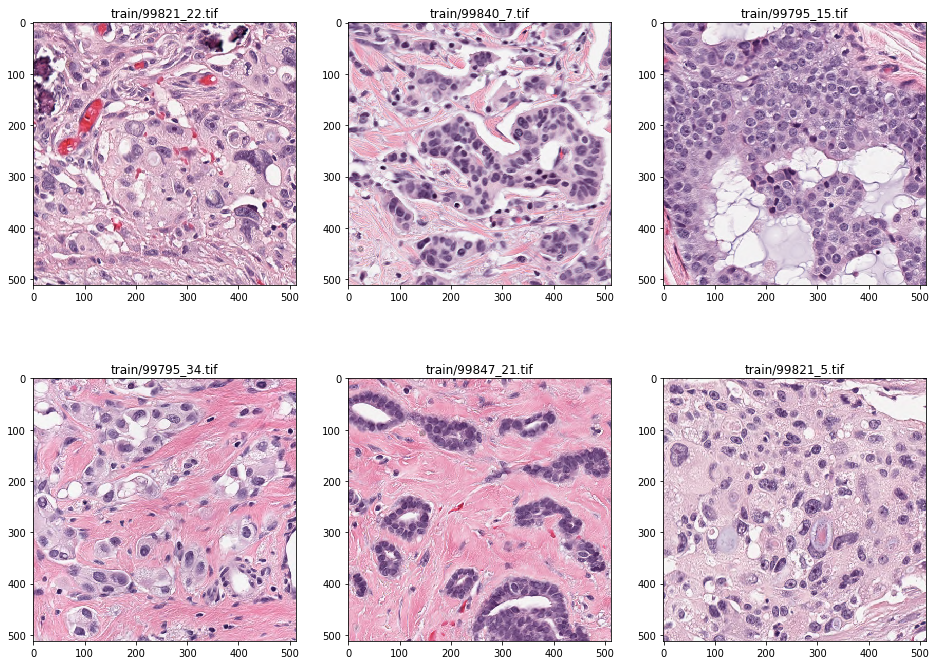

In [10]:
imgs = full_label.sample(6).slide_name
fig, axes = plt.subplots(2,3, figsize=(16,12))
for i, ax in enumerate(axes.flatten()):
    img = plt.imread("/data/Pathology/SPIE/training_set/breastpathq/datasets/"+ imgs.iloc[i])
    ax.imshow(img)
    ax.set_title(imgs.iloc[i])
plt.show()

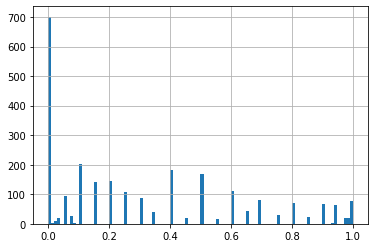

In [11]:
# histogram
full_label.y.hist(bins=100)

In [12]:
tfms = get_transforms(max_zoom=1., max_lighting=0.20, max_warp=None, do_flip=True, 
                      flip_vert=True, max_rotate=None,)
bs = 32  # batch size
sz= 512 # image size
root_dir = "/data/Pathology/SPIE/training_set/breastpathq/datasets/"
data = (ImageList.from_df(full_label, root_dir, cols=['slide_name'])
        #Where to find the data? -> in planet 'train' folder
        .split_from_df(col='is_valid')
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(cols='y')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms)
        #Data augmentation? -> use tfms with a size of 128
        .databunch(bs=bs, num_workers=16)
        .normalize(imagenet_stats))                          
        #Finally -> use the defaults for conversion to databunch

In [13]:
from pred import predprob
class CustomMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func):
        # If it's a partial, use func.func
        name = getattr(func,'func', func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.output, self.target = [], []

    def on_batch_end(self, last_output, last_target, train, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        #if not is_listy(last_target): last_target=[last_target]
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
        # self.val += last_target[0].size(0) * val.detach().cpu()
    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            # preds = F.softmax(output, dim=1)
            self.metric = self.func(target, output.view(-1).detach().cpu())
        return add_metrics(last_metrics, self.metric)

p_k = CustomMetric(predprob)

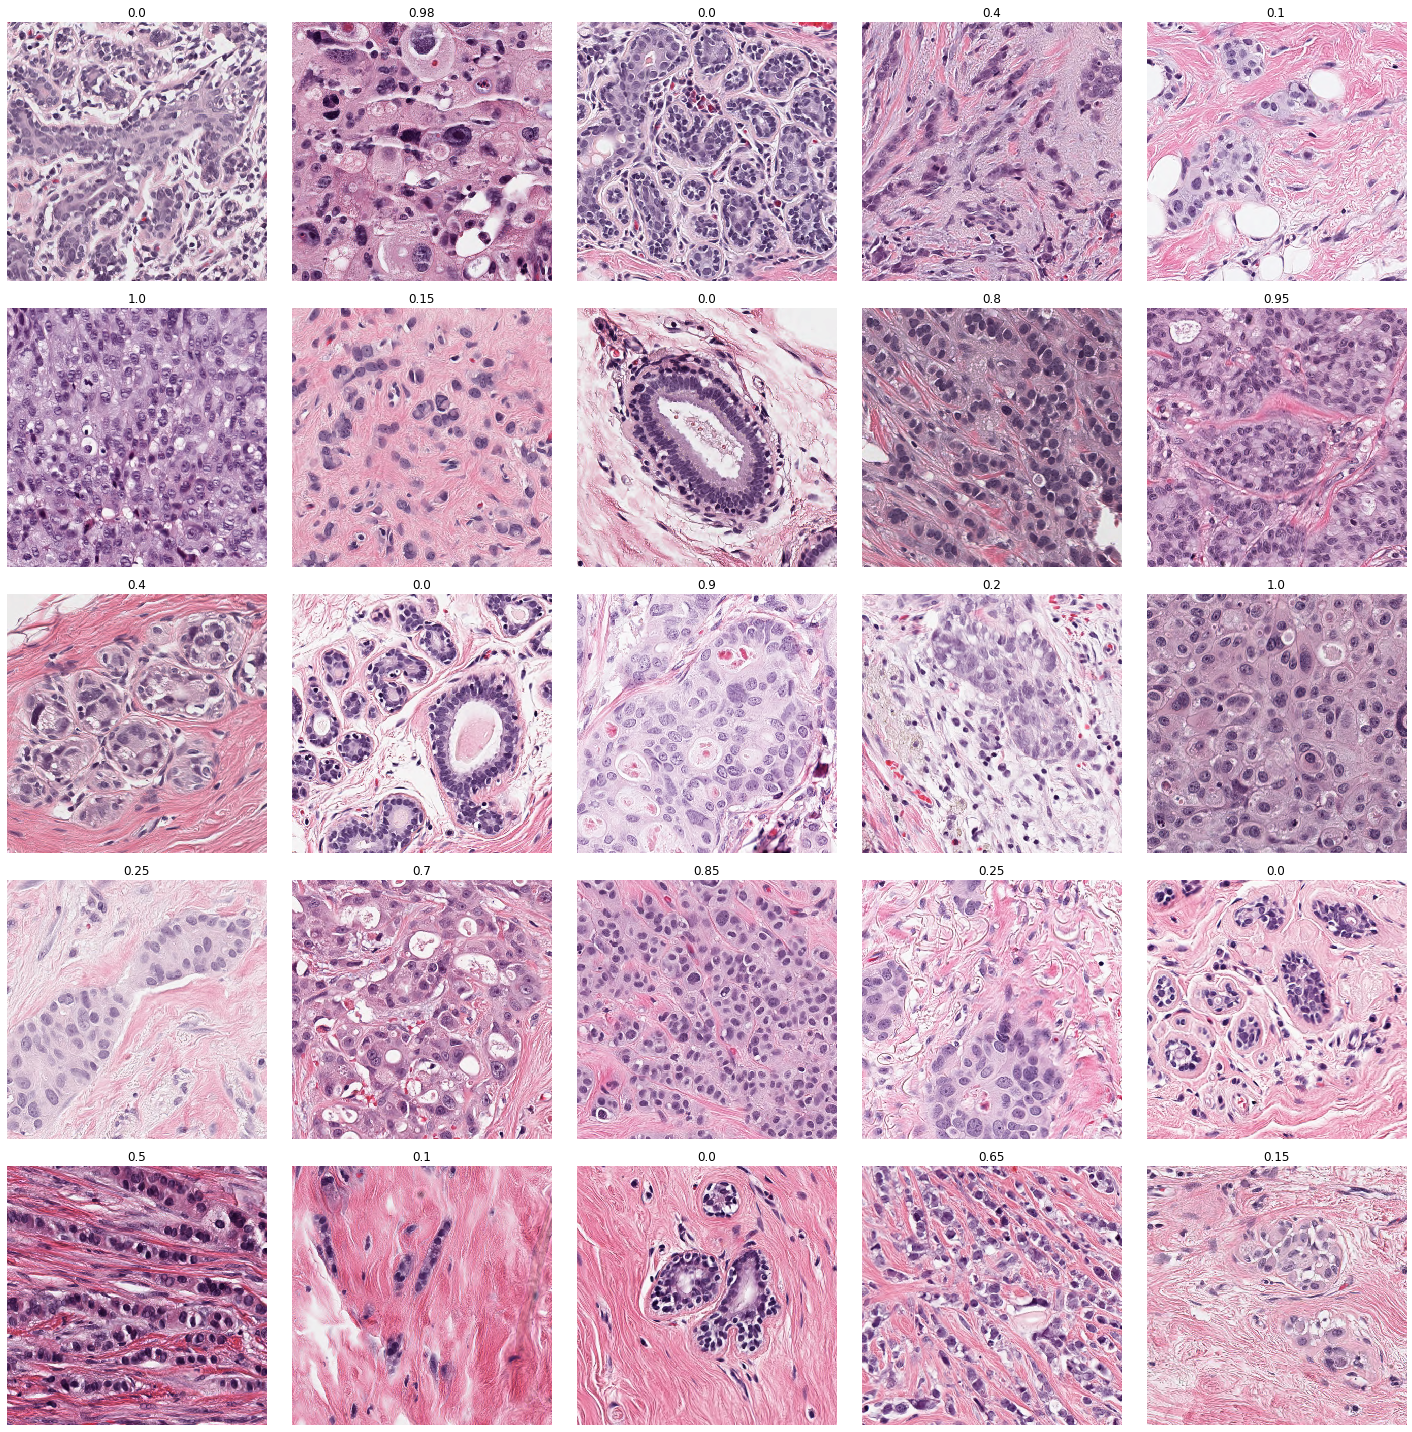

In [14]:
data.show_batch()

In [15]:
model_path = Path("/data/yuyue/SPIE/model_weight/")
learn = cnn_learner(data, models.densenet169, metrics=[mse,p_k], model_dir=model_path, 
                    loss_func=MSELossFlat(),  callback_fns=[ShowGraph,]).to_parallel()
# make output [0...1], don't foreget to add sigmoid at the end of model
# learn.model[1].add_module("sigmoid", module=nn.Sigmoid())

In [16]:
learn.data = data

In [17]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/root/anaconda2/envs/fastai/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/root/anaconda2/envs/fastai/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/root/anaconda2/envs/fastai/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 21, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/root/anaconda2/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/root/anaconda2/envs/fastai/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 276, in rebuild_storage_fd
    fd = df.detach()
  File "/root/anaconda2/envs/fastai/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/root/anaconda2/envs/fastai/lib/python3.7/multi

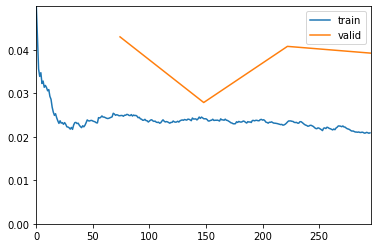

In [25]:
learn.fit_one_cycle(4, max_lr=1e-03)

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


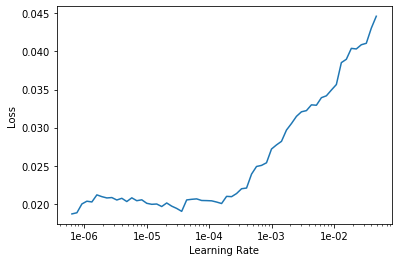

In [27]:
learn.lr_find()
learn.recorder.plot()

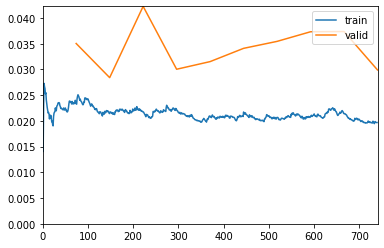

In [22]:
learn.fit_one_cycle(10, max_lr=slice(1e-6))

In [64]:
learn.save('/data/yuyue/SPIE/model_weight/densen169_fastai')

In [19]:
learn.load('/data/yuyue/SPIE/model_weight/densen169_fastai')

Learner(data=ImageDataBunch;

Train: LabelList (2394 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: FloatList
0.4,0.4,0.15,0.1,0.07
Path: /data/Pathology/SPIE/training_set/breastpathq/datasets;

Valid: LabelList (185 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: FloatList
0.9,0.95,0.9,0.7,0.8
Path: /data/Pathology/SPIE/training_set/breastpathq/datasets;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05

In [66]:
from pred import predprob
preds = learn.get_preds()
predprob(preds[1], preds[0])

0.8681297830624248

In [67]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_ru

In [69]:
torch.save(learn.model,'/data/yuyue/SPIE/model_weight/densen169_fastai_2_torch.pth')

NameError: name 'dill' is not defined